In [35]:
%matplotlib inline

In [34]:
import pandas as pd
import os
import numpy as np
import pickle
import string, re
import matplotlib.pyplot as plt
from langdetect import detect
from matplotlib.pyplot import figure

import nltk.collocations 
from nltk import FreqDist, word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import wordcloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from collections import Counter
from nltk.corpus import stopwords


import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import seaborn as sns

from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
#path_train = r'C:\Users\PC\Desktop\NN\NN Project\Best Lyrics\train'

In [4]:
#files = os.listdir(path_train)

## Explore datasets 

In [3]:
def read_file(directory):
    df = directory
    csv_file = pd.read_csv(df)
    return csv_file

In [6]:
train_data = read_file(r'C:\Users\PC\Desktop\NN\NN Project\Best Lyrics\train\train.csv')

### Keep only train dataset

In [128]:
#test_data = read_file(r'C:\Users\PC\Desktop\NN\NN Project\Best Lyrics\test\test.csv')

In [8]:
### genre is missing, is in combined_artist file - artist is the key got the genre
combined_lyrics = read_file(r'C:\Users\PC\Desktop\NN\NN Project\Best Lyrics\combined\lyrics-data.csv')

In [9]:
combined_artists = read_file(r'C:\Users\PC\Desktop\NN\NN Project\Best Lyrics\combined\artists-data.csv')

In [10]:
## check the size of the datasets
train_data.shape , #test_data.shape, combined_lyrics.shape

((290183, 5), (7935, 6), (209522, 5))

In [11]:
## check the columns
train_data.columns

Index(['Artist', 'Song', 'Genre', 'Language', 'Lyrics'], dtype='object')

In [12]:
#test_data.columns

Index(['Song', 'Song year', 'Artist', 'Genre', 'Lyrics', 'Track_id'], dtype='object')

In [13]:
train_data.groupby(['Genre']).size()

Genre
Country         1890
Electronic      2213
Folk            8644
Hip-Hop         2240
Indie           8449
Jazz           13545
Metal          20291
Pop           108714
R&B             2793
Rock          121404
dtype: int64

In [14]:
train_data.groupby(['Language']).size()

Language
af        77
ca       137
cs        17
cy       226
da        71
de       478
en    250197
es      3892
et        58
fi        54
fr       644
hr        97
hu        10
id       737
it       808
ko         1
lt         2
lv         2
nl       116
no        93
pl        24
pt     30102
ro      1184
ru         4
sk        98
sl        77
so       229
sq        15
sv        61
sw       304
tl       241
tr       116
vi         7
dtype: int64

In [15]:
#test_data.groupby(['Genre']).size()

Genre
Country        810
Electronic     660
Folk           495
Hip-Hop        960
Indie          510
Jazz           660
Metal          810
Pop           1110
R&B            510
Rock          1410
dtype: int64

The datasets are already separated on training and testing datasets. For our purposes they don't have the same features and - Language is missing from the training dataset, and we will need it because we will work only with English lyrics. Also the datasets are inbalanced. We will not work with whole 6 genres.

## Select only songs with English lyrics

### First Data set

In [16]:
train_data = train_data[train_data.Language== 'en']

In [17]:
train_data.groupby(['Genre']).size()

Genre
Country         1890
Electronic      2005
Folk            8169
Hip-Hop         2238
Indie           7240
Jazz           13314
Metal          19133
Pop            86298
R&B             2765
Rock          107145
dtype: int64

# !NB: Check if we will use the train data from the dataset or we will split it from lyrics_dataset

In [18]:
### test data doesn't have a language feature, so we have to detect it
### keep only English lyrics

def map_language(data):
    df = data.copy()
    df['Language'] = df['Lyrics'].apply(detect)
    return df

In [19]:
#test_data = map_language(test_data)

In [20]:
#test_data.Language.unique()

array(['en', 'sw', 'af', 'cy', 'tl', 'es'], dtype=object)

In [21]:
#test_datas = test_data[test_data.Language == 'en']

In [22]:
#test_datas.groupby(['Genre']).size()

Genre
Country        809
Electronic     660
Folk           494
Hip-Hop        960
Indie          510
Jazz           660
Metal          809
Pop           1109
R&B            509
Rock          1410
dtype: int64

In [23]:
#test_data.shape

(7935, 7)

In [24]:
## clear duplicates
#test_data.drop_duplicates(subset=['Artist','Song'])

,Song,Song year,Artist,Genre,Lyrics,Track_id,Language
0,craftsmanship,2005,buck-65,Hip-Hop,Most folks spend their days daydreaming of fin...,8294,en
1,come-on-out,2012,the-elwins,Indie,Take your cold hands and put them on my face\n...,21621,en
2,riot,2013,bullet-for-my-valentine,Metal,Are you ready it's time for war\nWe'll break d...,3301,en
3,that-s-what-girls-do,2007,dream-street,Pop,You ask me why I change the color of my hair\n...,2773,en
4,believe-in-a-dollar,2012,cassidy,Hip-Hop,Do you believe in magic in a young girl's hear...,16797,en
...,...,...,...,...,...,...,...
7930,too-little-too-late,2006,amanda-marshall,Rock,Tuesday night - 7:30\nI hear a voice on the te...,23453,en
7931,berserker,2007,aurora-borealis,Metal,Elite forces cloaked in fur un sensitive to pa...,2724,en
7932,natural-born-killaz,2010,dr-dre,Hip-Hop,[Dr. Dre]\nJourney with me\nInto the mind of a...,24147,en
7933,wide-awake,2011,chris-cornell,Rock,You can a look a hurricane right in the eye.\n...,4150,en


In [25]:
## check for duplicated tracks


grouped = train_data.groupby(['Artist','Song'], as_index=True).size()
grouped[grouped > 1].count()

33641

In [26]:
## clear duplicates
train_data.drop_duplicates(subset=['Artist','Song'], inplace = True)

In [27]:
## clear duplicates
test_data.drop_duplicates(subset=['Artist','Song'], inplace = True)

In [28]:
# Data Cleanup - making everything lower case
train_data['Song'] = train_data['Song'].astype(str).apply(lambda row:row.lower())
train_data['Artist'] = train_data['Artist'].apply(lambda row:row.lower())

In [29]:
## we have no missing data , 10 701 artists and 10 Genres
train_data.describe()

,Artist,Song,Genre,Language,Lyrics
count,210011,210011,210011,210011,210011
unique,10701,137661,10,1,199630
top,elvis presley,intro,Rock,en,"My heart is sad and lonely\nFor you I sigh, fo..."
freq,1019,123,90046,210011,89


## Clean up remix, version ... from songs' names

In [30]:
#for artist in train_data.Song.unique():
    #print(artist)

In [31]:
### we have both types of parenthesis and we want to split the name of the song by them, that is why we will replace '[' with '(' 
train_data['Song'] = train_data['Song'].astype(str).apply(lambda row: row.replace('[','('))

In [32]:
### test
#train_data[train_data["Song"].str.contains("remix")]["Song"].apply(lambda row: row.split('(')[0])

### Some songs have remixes 

In [33]:
#test
train_data['Song'].loc[1143]

'dream on (griz remix)'

In [34]:
### we want to remove remix from Song names in order to be able to clean up duplicates
train_data.loc[train_data["Song"].str.contains("remix"), 'Song'] = train_data["Song"].apply(lambda row: row.split('(')[0])

In [35]:
### test
train_data['Song'].loc[1143]

'dream on '

In [36]:
### we have remix outside of the parenthesis as well, we want to remove it as songs lyrics for original and remix are almost identical
train_data['Song'] = train_data['Song'].astype(str).apply(lambda row: row.replace('remix',''))

In [37]:
train_data

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...
...,...,...,...,...,...
290176,the blood brothers,beautiful horses,Indie,en,Ride! Ride! Ride! Ride! Ride! Ride! Ride the c...
290178,bobby womack,i wish he didn t trust me so much,R&B,en,I'm the best friend he's got I'd give him the ...
290179,bad boys blue,i totally miss you,Pop,en,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
290181,dan bern,cure for aids,Indie,en,The day they found a cure for AIDS The day the...


In [38]:
### test no songs with remix in the name are left in the data set
train_data[train_data["Song"].str.contains("remix")]

,Artist,Song,Genre,Language,Lyrics


### Some songs have version

In [39]:
train_data[train_data["Song"].str.contains("version")]

,Artist,Song,Genre,Language,Lyrics
362,311,reggae got soul (surf's up version),Rock,en,Reggae got soul\nGot so much soul\nReggae got ...
604,ac dc,the jack (live version),Rock,en,She gave me her mind\nThen she gave me her bod...
1526,afi,this celluloid dream (demo version),Pop,en,"Oh !\nCalling tears from deep inside,\nOh, you..."
1612,alanis morissette,everything (clean version),Rock,en,I can be a nightmare of the grandest kind\nI c...
1744,alanis morissette,versions of violence,Rock,en,Coercing or leaving\nShutting down and punishi...
...,...,...,...,...,...
287778,ciara,love you better main version,Pop,en,Look boy I cant stand yo butt You lucky im les...
289062,donna summer,spring affair single version,Pop,en,"Spring affair Ooh, something's coming over me ..."
289189,ellie goulding,the end studio version,Pop,en,We've only ever kissed lying down We've only e...
289202,erykah badu,tyrone extended version,Jazz,en,I'ma test this out right quick on y'all Now ke...


In [40]:
### we want to remove version from Song names in order to be able to clean up duplicates
train_data.loc[train_data["Song"].str.contains("version"), 'Song'] = train_data["Song"].apply(lambda row: row.split('(')[0])

In [41]:
train_data['Song'].loc[362]

'reggae got soul '

### Some songs have remaster

In [42]:
train_data[train_data["Song"].str.contains("remaster")]

,Artist,Song,Genre,Language,Lyrics
142568,the box tops,i shall be released (digitally remastered:1996],Pop,en,They say everything can be replaced\nYet every...
160172,isaac hayes,walk on by (remaster],Jazz,en,If you see me walking down the street\nAnd I s...
174802,leftfield,21st century poem (remastered],Electronic,en,"How many bridges can they burn, till we turn?\..."
187008,natalie merchant,carnival (remastered],Pop,en,"Well, I've walked these streets \nA virtual st..."
187009,natalie merchant,the lowlands of holland (with the chieftains] ...,Pop,en,On the night that I was married\nAnd upon my m...
187010,natalie merchant,photograph (with r.e.m.] (remastered],Pop,en,"I found this photograph,\nUnderneath the broke..."
188631,daryl hall & john oates,did it in a minute (remastered],Rock,en,When you find yourself alone\nAnd when going o...
188632,daryl hall & john oates,maneater (remastered],Rock,en,She'll only come out at night\nThe lean and hu...
188633,daryl hall & john oates,method of modern love (remastered],Rock,en,In the moonlite\nUnder startlite\nSongs old as...
188634,daryl hall & john oates,one on one (remastered],Rock,en,I'm tired of playing on the team\nIt seems I d...


In [43]:
### we want to remove remaster from Song names in order to be able to clean up duplicates
train_data.loc[train_data["Song"].str.contains("remaster"), 'Song'] = train_data["Song"].apply(lambda row: row.split('(')[0])

In [44]:
### test
train_data[train_data["Song"].str.contains("remaster")]

,Artist,Song,Genre,Language,Lyrics
275366,ella fitzgerald,we three kings 2006 remaster,Jazz,en,"[Chorus:] We three kings of Orient are, Bearin..."
278283,ella fitzgerald,hark the herald angels sing 2006 remaster,Jazz,en,"Hark the herald angels sing ""Glory to the newb..."
280565,ella fitzgerald,o come all ye faithful 2006 remaster,Jazz,en,O come all ye faithful Joyful and triumphant O...
286577,ella fitzgerald,joy to the world 2006 remaster,Jazz,en,"Joy to the world, the Lord is come Let earth r..."


### Some songs have radio edit

In [45]:
train_data[train_data["Song"].str.contains("radio edit")]

,Artist,Song,Genre,Language,Lyrics
12110,coldplay,a sky full of stars (radio edit),Pop,en,"'Cause you're a sky, cause you're a sky full o..."
30347,kt tunstall,feel it all/band jam (radio edit),Rock,en,I'm growing like a seed\nRain's been falling o...
65716,train,so damn fine (radio edit),Pop,en,Bridge\nHey Superfly\nGive this lonely girl a ...
73235,chamillionaire,ridin' dirty (radio edit),Pop,en,[Chorus]\nThey see me rollin\nThey hatin\nPatr...
81484,lil wayne,lollipop (uk radio edit),Pop,en,Hey pretty lady\n2009 (lollipop)\nWe already a...
...,...,...,...,...,...
252422,timbaland,give it to me (radio edit],Pop,en,How you want it I got it\nA minute or so\nI'm ...
256108,master p,let's ride (radio edit),Pop,en,let's get rowdy\nlet's get rowdy\nknow montell...
268849,"black keys, the",have love will travel (radio edit),Rock,en,if you need lovin'\noh baby\ni'll travel\ni'll...
274992,armin van buuren,black hole jorn van deynhoven radio edit,Electronic,en,You pull me up Here we go again And the heart ...


In [46]:
### we want to remove remaster from Song names in order to be able to clean up duplicates
train_data.loc[train_data["Song"].str.contains("radio edit"), 'Song'] = train_data["Song"].apply(lambda row: row.split('(')[0])

In [47]:
train_data[train_data["Song"].str.contains("radio edit")]

,Artist,Song,Genre,Language,Lyrics
274992,armin van buuren,black hole jorn van deynhoven radio edit,Electronic,en,You pull me up Here we go again And the heart ...
284225,dj bomba,amsterdam radio edit,Electronic,en,Crazy club with dutchy beats Our place for sex...


### Some songs have mix

In [48]:
train_data[train_data["Song"].str.contains("mix")]

,Artist,Song,Genre,Language,Lyrics
36,12 stones,broken-wwe mix,Rock,en,Alone again again alone\nPatiently waiting by ...
236,311,all mixed up,Rock,en,All Mixed Up\nMusic: Hexum; Lyrics: Hexum/Mart...
343,311,mix it up,Rock,en,You take a little bit of me\nAnd a whole lot o...
827,adam lambert,another lonely night (pop mix),Pop,en,Alone in the dark\nHole in my heart\nTurn on t...
3114,asking alexandria,the death of me (rock mix),Metal,en,Am I insane?\nI ask myself over and over and o...
...,...,...,...,...,...
286085,dj antoine,holiday vs mad mark 2k15 club mix,Electronic,en,"Akon, Antoine When you move I'm in another pla..."
286418,camp lo,sparkle mr midnight mix,Hip-Hop,en,We made the lyrics Nigga gon' tell me how I di...
286934,candee jay,lose this feeling xxl mix,Electronic,en,Oh no Not now Oh no Not ever Oh no Not now Oh ...
288526,faithless,mass destruction p nut and sister bliss mix,Electronic,en,Whether long range weapon or suicide bomber Wi...


In [49]:
### we want to remove remaster from Song names in order to be able to clean up duplicates
train_data.loc[train_data["Song"].str.contains("mix"), 'Song'] = train_data["Song"].apply(lambda row: row.split('(')[0])

In [50]:
train_data[train_data["Song"].str.contains("mix")]

,Artist,Song,Genre,Language,Lyrics
36,12 stones,broken-wwe mix,Rock,en,Alone again again alone\nPatiently waiting by ...
236,311,all mixed up,Rock,en,All Mixed Up\nMusic: Hexum; Lyrics: Hexum/Mart...
343,311,mix it up,Rock,en,You take a little bit of me\nAnd a whole lot o...
5215,beck,mixed bizness,Pop,en,I'm mixing business with leather\nChristmas wi...
6948,blur,mixed up,Rock,en,"Oh, You make me feel\nLike no one ever will\nW..."
...,...,...,...,...,...
286085,dj antoine,holiday vs mad mark 2k15 club mix,Electronic,en,"Akon, Antoine When you move I'm in another pla..."
286418,camp lo,sparkle mr midnight mix,Hip-Hop,en,We made the lyrics Nigga gon' tell me how I di...
286934,candee jay,lose this feeling xxl mix,Electronic,en,Oh no Not now Oh no Not ever Oh no Not now Oh ...
288526,faithless,mass destruction p nut and sister bliss mix,Electronic,en,Whether long range weapon or suicide bomber Wi...


In [51]:
train_data[train_data["Song"].str.contains("feat")]

,Artist,Song,Genre,Language,Lyrics
262,311,creature feature,Rock,en,I wanna do what's right\nBe kind to every sing...
799,adam lambert,we are the champions (feat. kris allen & queen),Pop,en,I've paid my dues\nTime after time\nI've done ...
807,adam lambert,welcome to the show (feat. laleh),Pop,en,"You know I have a veil\nAll covered up, to mys..."
831,adam lambert,"beth, detroit rock city & rock n roll all nite...",Pop,en,Beth I hear you calling\nBut I can't come home...
874,adam lambert,lucy (feat. brian may),Pop,en,She's off to party with the diamond dogs\nFrom...
...,...,...,...,...,...
274112,game,father like son featbusta rhymes,Hip-Hop,en,"[Verse 1: The Game] June 30th, 11:07 I got tha..."
274796,dem franchize boyz,bonus hidden track white t featjermaine dupri...,Hip-Hop,en,[Intro: Franchize] In my white tee Yup (In my ...
276463,atrocity,defeated intellect,Metal,en,I left cocaine - going insane my first time - ...
277574,dean martin,i feel like a feather in the breeze,Jazz,en,I feel like a feather in the breeze Riding on ...


In [52]:
train_data['Song'] = train_data["Song"].apply(lambda row: row.split('(')[0])

In [53]:
train_data

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...
...,...,...,...,...,...
290176,the blood brothers,beautiful horses,Indie,en,Ride! Ride! Ride! Ride! Ride! Ride! Ride the c...
290178,bobby womack,i wish he didn t trust me so much,R&B,en,I'm the best friend he's got I'd give him the ...
290179,bad boys blue,i totally miss you,Pop,en,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
290181,dan bern,cure for aids,Indie,en,The day they found a cure for AIDS The day the...


In [54]:
### remove duplicated songs and artists
train_data.drop_duplicates(subset=['Artist','Song'], inplace = True)

### Second Dataset

In [55]:
combined_lyrics = combined_lyrics[combined_lyrics.Idiom == 'ENGLISH']

In [56]:
#combined_lyrics['Genre'] = [genre  for genre in combined_artists['Genre'] if combined_lyrics['ALink'].isin(combined_artists['Link']).all()]

In [57]:
combined_lyrics.drop_duplicates(subset=['ALink','SName'],inplace = True)

In [58]:
combined_artists.drop_duplicates(subset=['Link'],inplace = True)

In [59]:
final = pd.merge(combined_lyrics, combined_artists, left_on="ALink", right_on="Link", how = 'inner')

In [60]:
final.groupby(['Genre']).size()

Genre
Funk Carioca       15
Hip Hop         13682
Pop             25732
Rock            47637
Samba              42
Sertanejo          51
dtype: int64

In [61]:
## we will take only hip-hop and pop from the Second data set as in the First one they are underrepresentd
final = final[(final.Genre == 'Hip Hop')|(final.Genre== 'Pop')]

In [62]:
# Data Cleanup - making everything lower case
final['SName'] = final['SName'].apply(lambda row:row.lower())
final['Artist'] = final['Artist'].apply(lambda row:row.lower())

In [63]:
final.head(1)

,ALink,SName,SLink,Lyric,Idiom,Artist,Songs,Popularity,Link,Genre,Genres
760,/adam-lambert/,whataya want from me,/adam-lambert/whataya-want-from-me.html,"Hey, slow it down. What do you want from me. W...",ENGLISH,adam lambert,110,1.4,/adam-lambert/,Pop,Pop; Pop/Rock; Rock; Romântico; Dance; Electro...


In [64]:
final['SName'] = final['SName'].astype(str).apply(lambda row: row.replace('[','('))

In [65]:
final['SName']  = final['SName'] .apply(lambda row: row.split('(')[0])

In [66]:
final = final[["Artist", "SName", "Lyric", 'Genre', 'Idiom']]

In [67]:
final.rename(columns ={'SName' : "Song", 'Lyric' : 'Lyrics', 'Idiom' : "Language"}, inplace  = True)

In [68]:
final['Song'] = final['Song'].astype(str).apply(lambda row: row.replace('remix',''))

In [69]:
### test if we have left some remix, version, radio edit etc. in songs' names
final[final["Song"].str.contains("concert")]

,Artist,Song,Lyrics,Genre,Language
68545,cash cash,concerta,shake. are you ever here?. Ohh-Ohh-Ohh-Ohh. Ca...,Pop,ENGLISH
78396,madonna,charity concert/the art of the possible,(Magaldi:). On this night. On this night. On t...,Pop,ENGLISH


In [70]:
### remove duplicated songs and artists
final.drop_duplicates(subset=['Artist','Song'], inplace = True)

In [71]:
train_data.Genre.unique()

array(['Rock', 'Metal', 'Pop', 'Indie', 'Folk', 'Electronic', 'R&B',
       'Jazz', 'Hip-Hop', 'Country'], dtype=object)

In [72]:
## rename Hip Hop to be Hip-Hop to be the same as in dataset 1
final['Genre'] = final['Genre'].str.replace('Hip Hop', 'Hip-Hop')

In [73]:
final.Genre.unique()

array(['Pop', 'Hip-Hop'], dtype=object)

### Combining both train and Second dataset

In [74]:
train_data.shape[0] + final.shape[0]

247262

In [75]:
## combine datasets on artist name, beforehand mamke song and artist lowercase

In [76]:
lyrics_dataset = train_data.append(final, ignore_index = True)

In [77]:
final.head(1)

,Artist,Song,Lyrics,Genre,Language
760,adam lambert,whataya want from me,"Hey, slow it down. What do you want from me. W...",Pop,ENGLISH


In [78]:
### remove duplicated songs and artists
lyrics_dataset.drop_duplicates(subset=['Artist','Song'], inplace = True)

In [79]:
lyrics_dataset.shape

(217110, 5)

In [80]:
### is this accurate?
lyrics_dataset[lyrics_dataset.Lyrics.duplicated()]

,Artist,Song,Genre,Language,Lyrics
261,311,leaving babylon,Rock,en,My computer is future shockin’\ndownload this ...
267,311,livin' & rockin',Rock,en,My computer is future shockin’\ndownload this ...
272,311,mindspin,Rock,en,My computer is future shockin’\ndownload this ...
991,aerosmith,write me a letter,Rock,en,WRITE ME A LETTER\nguitar 1(Joe)\nE-----------...
1455,alesana,second guessing,Metal,en,These eyes they have seen the world\nThese fee...
...,...,...,...,...,...
234583,james biaggie,she lose a man,Pop,ENGLISH,She been gone since three thirty. Been coming ...
234584,james biaggie,ugly,Pop,ENGLISH,I use to think that you were beautiful. But no...
236892,katy b,crossover,Pop,ENGLISH,(katy b). Sweet imagination. Sweet imagination...
241070,nicola roberts,everybody's got to learn sometimes,Pop,ENGLISH,Change your heart. Look around you. Change you...


In [81]:
## test
'''
t = lyrics_dataset["Lyrics"].apply(lambda row: re.sub('\d+','', row))
t = lyrics_dataset["Lyrics"].apply(lambda row: re.sub('\s+', ' ', row))
'''


'\nt = lyrics_dataset["Lyrics"].apply(lambda row: re.sub(\'\\d+\',\'\', row))\nt = lyrics_dataset["Lyrics"].apply(lambda row: re.sub(\'\\s+\', \' \', row))\n'

In [82]:
lyrics_dataset.describe()

,Artist,Song,Genre,Language,Lyrics
count,217110,217110,217110,217110,217110
unique,10920,136497,10,2,207084
top,elvis presley,,Rock,en,"My heart is sad and lonely\nFor you I sigh, fo..."
freq,959,355,89313,208279,89


### Clean the lyrics

In [83]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub(r"\d+",'', text)
    text = re.sub(r"\s+", ' ', text)
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

In [84]:
lyrics_dataset['Lyrics'] = lyrics_dataset['Lyrics'].map(clean_text)

In [85]:
### Remove double space from the lyrics
lyrics_dataset['Lyrics'] = lyrics_dataset['Lyrics'].replace(r'\s+', ' ', regex=True)

In [86]:
lyrics_dataset['Lyrics'] = lyrics_dataset['Lyrics'].apply(lambda x: x.rstrip())

### Analyze the lyrics

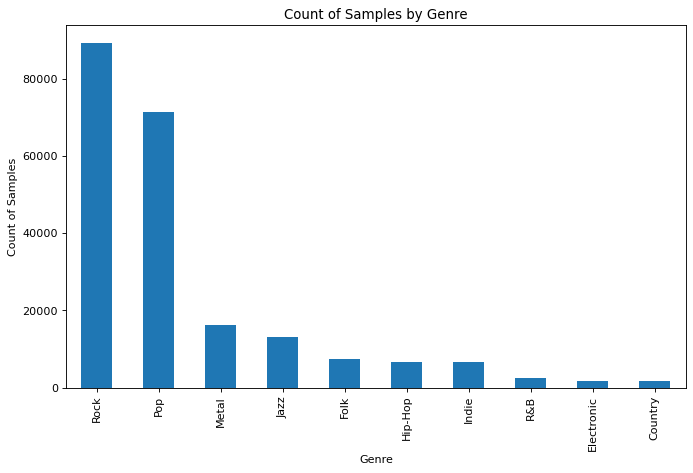

In [87]:
### We have unbalanced data set
figure(figsize = (10,6), dpi = 80)
plot = lyrics_dataset['Genre'].value_counts().plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count of Samples')
plt.title('Count of Samples by Genre')
plt.show()


We will not work with all Genres, we will keep some of them

In [88]:
lyrics_dataset = lyrics_dataset.loc[(lyrics_dataset.Genre == 'Rock') | (lyrics_dataset.Genre == 'Pop') | (lyrics_dataset.Genre == 'Hip-Hop') |  (lyrics_dataset.Genre == 'Jazz') |  (lyrics_dataset.Genre == 'Metal')]

In [89]:
lyrics_dataset.groupby(['Genre']).size()

Genre
Hip-Hop     6755
Jazz       13017
Metal      16336
Pop        71454
Rock       89313
dtype: int64

In [90]:
lyrics_dataset.columns

Index(['Artist', 'Song', 'Genre', 'Language', 'Lyrics'], dtype='object')

In [91]:
lyrics_dataset['count_words'] = ''
lyrics_dataset['count_words']= lyrics_dataset.Lyrics.str.count(' ') + 1


In [92]:
#test
lyrics_dataset[lyrics_dataset.Genre == 'Jazz'].count_words.mean()

169.69055850042253

In [93]:
#lyrics_dataset.Lyrics.str.count(' ') + 1

In [94]:
#test
lyrics_dataset[lyrics_dataset.Genre == 'Rock'].Lyrics.loc[208264]

'whats all this space junk these gems behind my eyes wed like to meet you your hopeless enterprise its better to love you than it is to know you big trash on the radar wed really like to be alone small hands on the fader the way you look right through me brings me home these superstitions kissed your black eyes blind hey what a shame you cant see yourself through mine its better to love you than it is to know you youre nobodys no one and no ones on your mind six feet down in the ether a graveyard in the stars its better to love you than it is to know you its finally time to wake you up the call came in you made the cut its only now you find the truth that everything was real'

In [95]:
#test_lyrics_df = lyrics_dataset.copy()
#test_lyrics_df['Lyrics'] = test_lyrics_df['Lyrics'].replace(r'\s+', ' ', regex=True)
#test_lyrics_df['Lyrics'] = test_lyrics_df['Lyrics'].apply(lambda x: x.rstrip())
#test_lyrics_df[test_lyrics_df.Genre == 'Pop'].Lyrics.str.count(' ') +1

In [96]:
#test_lyrics_df[test_lyrics_df.Genre == 'Pop'].Lyrics.loc[247210].replace('  ', ' ')

In [97]:
#test_lyrics_df[test_lyrics_df.Genre == 'Pop'].Lyrics.loc[247210]

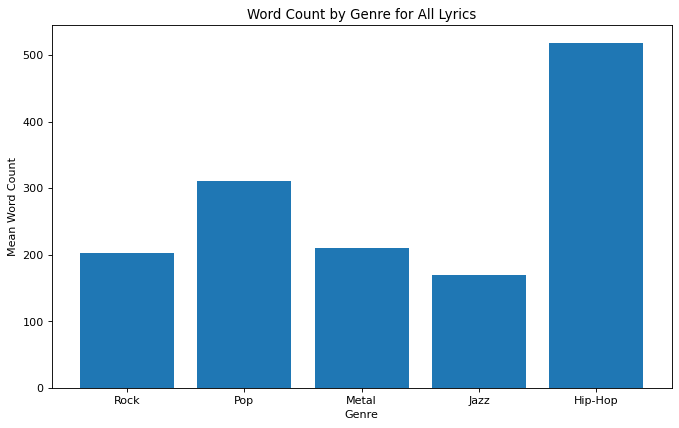

In [98]:

figure(figsize = (10,6), dpi = 80)
dict_genres={genre:index for index,genre in enumerate(lyrics_dataset.Genre.value_counts().keys())}
genre_means = [(genre,lyrics_dataset[lyrics_dataset['Genre'] == genre].count_words.mean()) for genre in dict_genres.keys()] 
genres = [genre for (genre,mean) in genre_means]
means = [mean for (genre,mean) in genre_means]
plt.bar(genres,means)
plt.xticks(genres)
plt.xlabel('Genre')
plt.ylabel('Mean Word Count')
plt.title('Word Count by Genre for All Lyrics')
plt.show()



In [99]:
lyrics_dataset.where((lyrics_dataset.count_words >20 ) & (lyrics_dataset.count_words < 30)).dropna().sort_values(by='count_words')

,Artist,Song,Genre,Language,Lyrics,count_words
95747,glenn tipton,baptizm of fire,Metal,en,so youve come of age and so you want to meet g...,21.0
11457,elvis presley,aloha-oe,Rock,en,aloha oe aloha oe ikeona ona noho ikanipo one ...,21.0
171145,savatage,the ocean,Metal,en,when the night will gather darkness and black ...,21.0
134324,samael,epilogue,Metal,en,in a world of sorrow a tormented soul dreams o...,21.0
38675,the beatles,wild honey pie,Rock,en,honey pie honey pie honey pie honey pie honey ...,21.0
...,...,...,...,...,...,...
189368,ben folds five,satan is my master,Rock,en,satan is my master he has always been he tells...,29.0
189632,beyonce,run away,Pop,en,simba what have you done it was a stampede he ...,29.0
28960,pink floyd,stop,Rock,en,i wanna go home take off this uniform and leav...,29.0
145816,david bowie,chant of the ever circling skeletal family,Rock,en,chant x brother ooh ooh shake it up shake it u...,29.0


In [100]:
lyrics_dataset.where(lyrics_dataset.count_words > 2000 ).dropna()

,Artist,Song,Genre,Language,Lyrics,count_words
28852,pink floyd,the wall,Rock,en,in the flesh we came in so ya thought ya might...,3288.0
30357,rammstein,mutter complete album lyrics english,Metal,en,mutter mein herz brennt my heart burns now dea...,2099.0
57875,the game,one blood,Pop,en,one blood feat jim jones snoop dogg nas t i fa...,2118.0
57879,the game,300 bars & runnin’,Pop,en,intro my mama took me to sam goodys i wanted ...,3108.0
115059,bal-sagoth,the obsidian crown unbound,Metal,en,episode ix from sage daeluns chronicles of an...,2529.0
137291,arlo guthrie,alice's restaurant massacree,Rock,en,you can get anything you want at alices restau...,2495.0
216347,j. cole,note to self,Hip-Hop,ENGLISH,and wherever we go and whatever we do and what...,2321.0
217523,kanye west,last call,Hip-Hop,ENGLISH,intro jay z kanye laughing yo fuck you kanye ...,2668.0


In [101]:
lyrics_dataset.loc[lyrics_dataset.count_words < 20]

,Artist,Song,Genre,Language,Lyrics,count_words
419,a day to remember,intro,Metal,en,i trusted you wake up ive been watching you,10
1283,alanis morissette,movement ix: faith,Rock,en,my unborn forgive me i only wish i had the str...,19
1439,alesana,icarus,Metal,en,black engulfs the dying light as he falls on f...,15
2297,angra,unfinished allegro,Metal,en,unfinished allegro instrumental,3
2466,asking alexandria,aleorion,Metal,en,fuck this cross my heart i hope you die left b...,18
...,...,...,...,...,...,...
231332,deee lite,"vote, baby, vote",Pop,ENGLISH,vote baby vote vote baby vote are you register...,10
234764,janet jackson,back,Pop,ENGLISH,computer i hope youve enjoyed your discipline,7
237584,kharlles,part. 2 experience album,Pop,ENGLISH,i say for you love yourself only this only lov...,16
237958,lari pádua,intro,Pop,ENGLISH,instrumental song,2


We will not use lyrrics with lenght less than 20 words( usually are intros)

In [102]:
lyrics_dataset = lyrics_dataset.loc[lyrics_dataset.count_words > 20]

In [103]:
%store lyrics_dataset

Stored 'lyrics_dataset' (DataFrame)


### Lemmatize the words

In [105]:
### tokenization of the text, removing stop words and lemmatization

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

lemmatizer = WordNetLemmatizer()
english = list(set(nltk.corpus.words.words()))

def clean_docs_lemma(df):

    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for artist, song, lyric, genre in zip(df.Artist, df.Song, df.Lyrics, df.Genre):
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words #list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        stopwords_list += ['embedshare','urlcopyembedcopy', 'feat',"i'm","i'll","i've", "you've", "i'd"]
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped if word!='']
        
        c = " ".join(lyric_lemmas)
       
        row = df[(df.Artist == artist) & (df.Song == song)].index.item()
        df.at[row,'Lyrics'] = c
    return df

In [106]:
lemmed_lyrics = clean_docs_lemma(lyrics_dataset)

In [269]:
### check the lyrics language

def map_language(data):
    df = data.copy()
    df['Language_test'] = df['Lyrics'].apply(detect)
    return df

In [274]:
mapped_df = map_language(lemmed_lyrics)

In [277]:
mapped_df.Language_test.unique()

array(['en', 'so', 'sv', 'nl', 'da', 'no', 'it', 'af', 'tl', 'fr', 'id',
       'sl', 'pl', 'cy', 'ca', 'pt', 'de', 'sw', 'es', 'et', 'hr', 'hu',
       'fi', 'ro', 'sq', 'tr', 'sk'], dtype=object)

In [283]:
lemmed_lyrics = mapped_df.loc[mapped_df.Language_test == 'en']

### Check the text of the longest and shortest lyrics - highest word count, some might need to be cleaned

In [286]:
lemmed_lyrics.loc[lemmed_lyrics.count_words >=800].sort_values(by = 'count_words', ascending = False)

,Artist,Song,Genre,Language,Lyrics,count_words,negative,neutral,positive,compound,Language_test
52038,lil jon the east side boyz,bia' bia',Pop,en,aiyyo check supreme figga nigga big kap rockin...,800,0.185,0.604,0.211,0.1154,en
119808,lil jon,bia' bia',Pop,en,aiyyo check supreme figga nigga big kap rockin...,800,0.185,0.604,0.211,0.1154,en
189231,lil jon,bia' bia',Hip-Hop,ENGLISH,aiyyo check supreme figga nigga big kap rockin...,800,0.185,0.604,0.211,0.1154,en


In [288]:
for text in lemmed_lyrics.loc[lemmed_lyrics.count_words >=800].sort_values(by = 'count_words', ascending = False ).Lyrics:
    print(f"Sample  - '\n' {text}")

Sample  - '
' aiyyo check supreme figga nigga big kap rockin lil jon eastside boyz chyna whyte ludacris nigga hort dog ay tell niggaz whats though scared get fuck club nigga bia bia get em get em actin like like push em push em bia bia get em get em fussin like like push em push em bia bia get em get em lookin like like push em push em bia bia get get em frontin like like push em push em bia bia get em get em actin like like push em push em bia bia get em get em fussin like like push em push em bia bia get em get em lookin like like push em push em bia bia get get em frontin like like push em push em well get em get em put em put em stop actin like bitch get yo hand well get em get em put em put em stop actin like bitch get yo hand well nigga nigga god dammit motherfucker nigga nigga god dammit motherfucker well represent yo shit represent yo shit say fuck clique say fuck clique represent yo shit represent yo shit say fuck clique say fuck clique well scared scared scared scared stop ac

Most of the lyrics of those songs are wrong and will cut them from the dataset that we will work with.

In [289]:
lemmed_lyrics = lemmed_lyrics.reset_index()

In [290]:
lemmed_lyrics['count_words']= lemmed_lyrics.Lyrics.str.count(' ') + 1

In [291]:
lemmed_lyrics = lemmed_lyrics.loc[(lemmed_lyrics.count_words >=20) &(lemmed_lyrics.count_words <=800)]

In [292]:
lemmed_lyrics = lemmed_lyrics.reset_index(drop=True)

In [293]:
%store lemmed_lyrics

Stored 'lemmed_lyrics' (DataFrame)


In [3]:
%store -r lemmed_lyrics

In [181]:
### test
lemmed_lyrics.Lyrics.loc[194419]

'know know climbed highest mountain top world came crashing fame fortune turned dust dirt couldnt turn back around many day felt helpless many night full sadness maybe meant got nothing nothing left lose got freedom got love got time remain others heart could leave behind start anew long got long got front page story making lie turning life around life around camera flashing blinding eye see clearer oh cause im still breathing new beginning baby meant got nothing nothing left lose got freedom got love got time remain others heart could leave behind start anew long got long got got nothing nothing left lose got freedom oh could anything want let go others arm lonely night dirty hotel room got love got time remain others life could leave behind start anew long got rain wont stop cold wont scar nobody gonna hold got nothing nothing left lose got freedom got love got time remain others heart could leave behind start anew long got long got got nothing nothing left lose got freedom could any

### Word Cloud vizualization

**Using Term Frequency Counter to show the top words per genre**

In [208]:
"""

def word_freq(df):
    
    df = lemmed_lyrics.where(lemmed_lyrics.genre_name == genre).dropna()
    vectorizer = CountVectorizer(stop_words = english_stop_words, min_df=0.1,max_df=0.7)
    doc_matrix = vectorizer.fit_transform(df.lyrics)
    doc_matrix = pd.DataFrame(doc_matrix.toarray(), columns=vectorizer.get_feature_names())
    a = (doc_matrix.sum()).to_dict()
    tf_dict = dict(sorted(a.items(), key=lambda item: -item[1]))

    return tf_dict
"""


In [294]:
music_generes = ('Rock', 'Pop','Jazz','Metal','Hip-Hop')

In [207]:
def plot_words(df):
    for g in music_generes:
        vectorizer = CountVectorizer(min_df=0.1,max_df=0.7)
        doc_matrix = vectorizer.fit_transform(df[df.Genre == g].Lyrics)
        doc_matrix = pd.DataFrame(doc_matrix.toarray(), columns=vectorizer.get_feature_names())
        a = (doc_matrix.sum()).to_dict()
        tf_dict = dict(sorted(a.items(), key=lambda item: -item[1]))

        print("Top 20 words in :", g)
        wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate_from_frequencies(tf_dict) 
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    

Top 20 words in : Rock


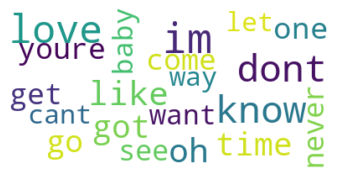

Top 20 words in : Pop


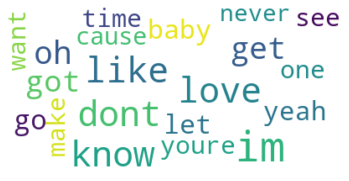

Top 20 words in : Jazz


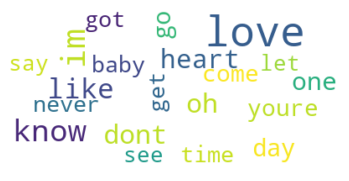

Top 20 words in : Metal


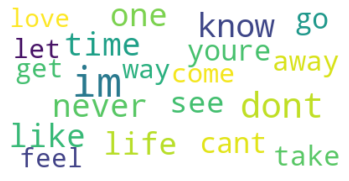

Top 20 words in : Hip-Hop


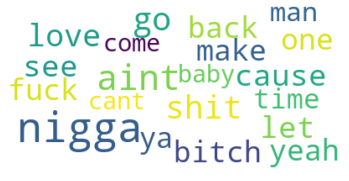

In [208]:
plot_words(lemmed_lyrics)

In [205]:
"""
for g in dict_genres.keys():
    text = ''
    for word in lemmed_lyrics[lemmed_lyrics.Genre == g].Lyrics:
        text = text+word
    print("Word cloud of :", g)
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text) 
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


"""


'\nfor g in dict_genres.keys():\n    text = \'\'\n    for word in lemmed_lyrics[lemmed_lyrics.Genre == g].Lyrics:\n        text = text+word\n    print("Word cloud of :", g)\n    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text) \n    plt.figure()\n    plt.imshow(wordcloud, interpolation="bilinear")\n    plt.axis("off")\n    plt.show()\n\n\n'

In [117]:
sentiment_lyrics = lemmed_lyrics.copy()

### Sentiment Analyzis NLTK

VADER ( Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is available in the NLTK package and can be applied directly to unlabeled text data
[reference](https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664)

In [118]:
#Create lists to store the different scores for each word
negative = []
neutral = []
positive = []
compound = []
#Initialize the model
sid = SentimentIntensityAnalyzer()
#Iterate for each row of lyrics and append the scores
for i in lemmed_lyrics.index:
    scores = sid.polarity_scores(lemmed_lyrics['Lyrics'].iloc[i])
    negative.append(scores['neg'])
    neutral.append(scores['neu'])
    positive.append(scores['pos'])
    compound.append(scores['compound'])
#Create 4 columns to the main data frame  for each score
lemmed_lyrics['negative'] = negative
lemmed_lyrics['neutral'] = neutral
lemmed_lyrics['positive'] = positive
lemmed_lyrics['compound'] = compound


In [119]:
lemmed_lyrics = lemmed_lyrics.drop(['index'], axis = 1)

In [120]:
#words = ' '.join(lemmed_lyrics[lemmed_lyrics.Genre == 'Rock'].Lyrics)

In [20]:
lemmed_lyrics.groupby(['Genre']).mean()

,index,count_words,negative,neutral,positive,compound
Genre,,,,,,
Hip-Hop,187072.940489,291.112727,0.168785,0.651825,0.179382,-0.042960
Jazz,128059.077773,88.870457,0.119296,0.590401,0.290307,0.573501
Metal,97590.863406,111.497595,0.234175,0.587907,0.177923,-0.247616
Pop,97013.621788,166.716438,0.139804,0.634034,0.226165,0.342948
Rock,86986.244162,106.716120,0.143824,0.632840,0.223334,0.316292


In [78]:
%store lemmed_lyrics

Stored 'lemmed_lyrics' (DataFrame)


In [156]:
lemmed_lyrics.negative.mean() , lemmed_lyrics.compound.max()

(0.1484905417090926, 1.0)

Now will call out compound as a separate column and all values greater than zeroes will be considered a positive review and all values less than zero would be considered as a negative review.

In [189]:
positive_lyrics = lemmed_lyrics.where(lemmed_lyrics.compound >0).dropna().Lyrics
negative_lyrics = lemmed_lyrics.where(lemmed_lyrics.compound <0).dropna().Lyrics
neutral_lyrics = lemmed_lyrics.where(lemmed_lyrics.compound == 0).dropna().Lyrics

In [194]:
lemmed_lyrics.where((lemmed_lyrics.compound < 0) &(lemmed_lyrics.Genre == 'Pop')).dropna().Lyrics

360       starry night bring till realize moon seems dis...
361       every time wake mornin start cry figure someth...
363       tell wellness well make mistake yeah please ex...
368       wonderful hesitation would bear feel sorry dro...
643       died last night dream walking street old ghost...
                                ...                        
195403    woke monday morning come getting dark hell lig...
195415    oh girl prettier expect expect oh girl trust w...
195416    christmas coming christmas coming christmas co...
195420    left alone forget heart day need ask better gi...
195423    lipstick stain place start day youre scratchin...
Name: Lyrics, Length: 22449, dtype: object

### Visualize top 20 positive words per genre

Top 20 words in : Rock


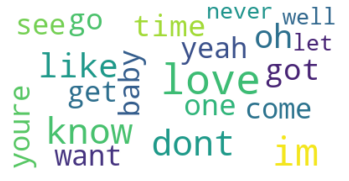

Top 20 words in : Pop


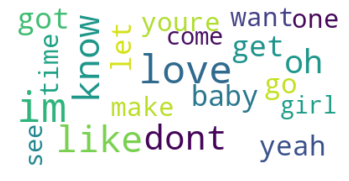

Top 20 words in : Jazz


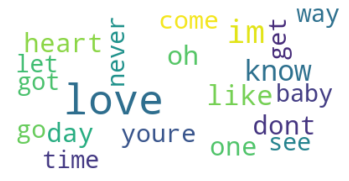

Top 20 words in : Metal


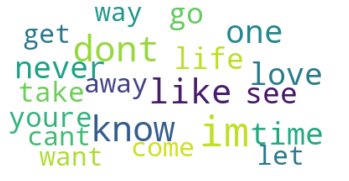

Top 20 words in : Hip-Hop


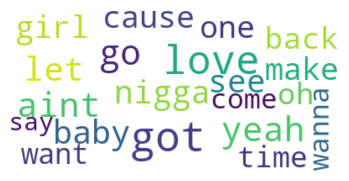

In [209]:
plot_words(lemmed_lyrics.where((lemmed_lyrics.compound >= 0)).dropna())

### Visualize top 20 negative words per genre

We should have in mind that the negativly loaded words are and those that have don't, can't etc. before the word.

Top 20 words in : Rock


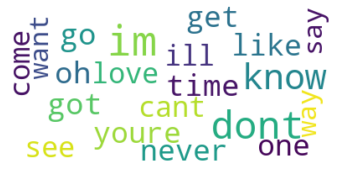

Top 20 words in : Pop


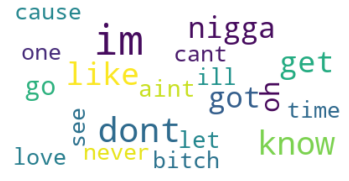

Top 20 words in : Metal


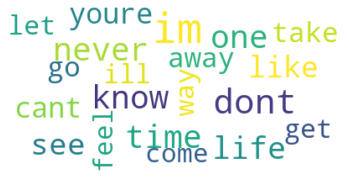

Top 20 words in : Jazz


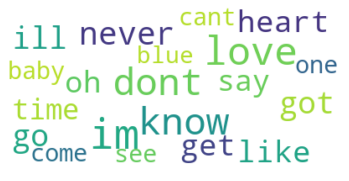

Top 20 words in : Hip-Hop


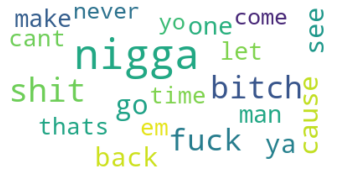

In [231]:
plot_words(lemmed_lyrics.where((lemmed_lyrics.compound <0)).dropna())

Word cloud top 20 Positive: Rock


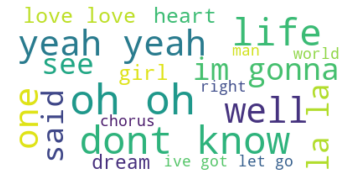

Word cloud top 20 Positive: Pop


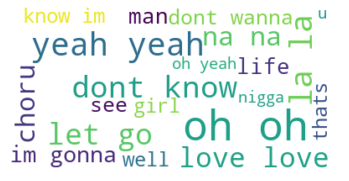

Word cloud top 20 Positive: Jazz


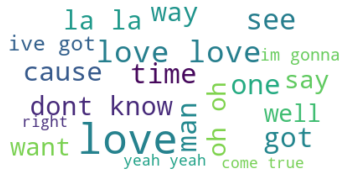

Word cloud top 20 Positive: Metal


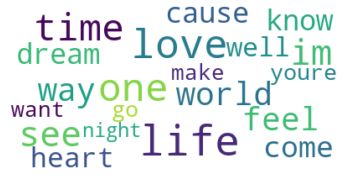

Word cloud top 20 Positive: Hip-Hop


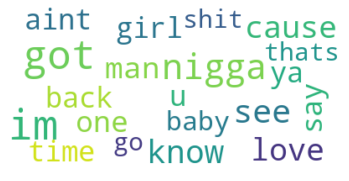

In [211]:
for g in music_generes:
    text = ''
    for word in lemmed_lyrics.where((lemmed_lyrics.compound >= 0) &(lemmed_lyrics.Genre == g)).dropna().Lyrics:
        text = text+word
    print("Word cloud top 20 Positive:", g)
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(text) 
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [295]:
sentiment_mean = lemmed_lyrics.groupby(['Genre']).mean().reset_index()

In [296]:
sentiment_mean.count_words = sentiment_mean.count_words.astype('int')

In [323]:
### test
sentiment_mean

,Genre,count_words,negative,neutral,positive,compound
0,Hip-Hop,292,0.168329,0.652349,0.179315,-0.041153
1,Jazz,89,0.118786,0.591914,0.289303,0.572855
2,Metal,111,0.233795,0.588467,0.177742,-0.246770
3,Pop,167,0.138992,0.635400,0.225610,0.344427
4,Rock,106,0.143384,0.633431,0.223183,0.316721


In [321]:
#lemmed_lyrics.groupby(['Genre']).mean().reset_index()

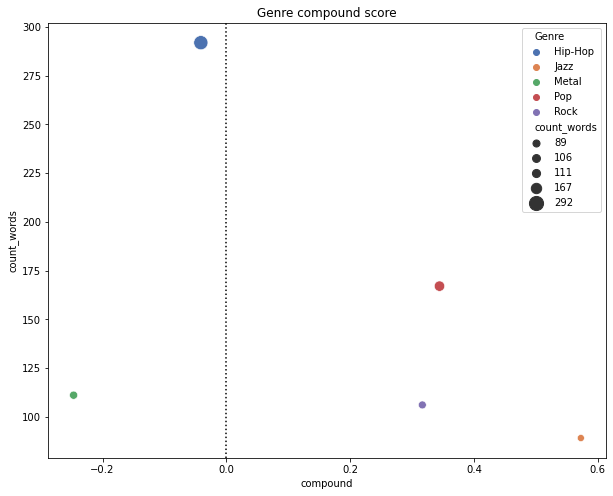

In [320]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=sentiment_mean, x="compound", y="count_words", hue="Genre",size = 'count_words',sizes=(50, 200), palette = "deep")
plt.axvline(0,color = 'k', linestyle = 'dotted' )
plt.title('Genre compound score')
plt.show()

Based on the graphic above, metal and hip-hop have mean compound score bellow zero, as metal is the genre with the most negative lyrics. On the other hand Jazz is the genre with most positive mean score.

In [303]:
'''
means_df =  lemmed_lyrics.groupby(['Genre']).mean()
for name, group in means_df.groupby('Genre'):
    plt.scatter(group[group['compound']>=0],group[group['compound']<0],label=name)
    plt.legend()
plt.xlim([-0.05,0.7])
plt.ylim([-0.05,0.7])
plt.title("Lyrics Sentiments by genre")
plt.xlabel('Positive Valence')
plt.ylabel('Negative  Valence')
plt.show()


'''


'\nmeans_df =  lemmed_lyrics.groupby([\'Genre\']).mean()\nfor name, group in means_df.groupby(\'Genre\'):\n    plt.scatter(group[group[\'compound\']>=0],group[group[\'compound\']<0],label=name)\n    plt.legend()\nplt.xlim([-0.05,0.7])\nplt.ylim([-0.05,0.7])\nplt.title("Lyrics Sentiments by genre")\nplt.xlabel(\'Positive Valence\')\nplt.ylabel(\'Negative  Valence\')\nplt.show()\n\n\n'

### Separate the text into training and testing - from lemmed lyrics

### Text is ready to be preprocessed with keras

In [297]:
lemmed_lyrics.groupby(['Genre']).Lyrics.count()

Genre
Hip-Hop     6671
Jazz       12768
Metal      16011
Pop        69900
Rock       87618
Name: Lyrics, dtype: int64

Music genres are not represented equally, we have to work either with highly imbalanced dataset ( hip-hp has ~ 7k samples, whereas Rock has ~88K samples)or 'cut'some of the samples.

Based on the results we got from previous reserach, we discovered that Pop genre was the most 'fluid' one as it was mistaken the most, mainly with r&b and hip-hop and the least with metal. We can keep Pop and drop hip-hop,  

In [213]:
#rock =lemmed_lyrics[lemmed_lyrics.Genre== "Rock"].sample(n = 20000, random_state = 42).reset_index(drop = True)

In [298]:
lemmed_lyrics.Language.unique()

array(['en', 'ENGLISH'], dtype=object)

In [299]:
lemmed_lyrics[lemmed_lyrics.Genre=="Jazz"]

,index,Artist,Song,Genre,Language,Lyrics,count_words,negative,neutral,positive,compound,Language_test
78386,79451,elis regina,golden slumbers,Jazz,en,way get back homeward way get back home sleep ...,70,0.125,0.664,0.211,0.8290,en
78387,79452,elis regina,triste,Jazz,en,sad live solitude far tranquil altitude sad kn...,33,0.315,0.511,0.174,-0.8249,en
78388,79453,elis regina,watch what happens,Jazz,en,let someone start believing let hold hand let ...,89,0.049,0.568,0.383,0.9914,en
78438,79506,ella fitzgerald,its only a paper moon,Jazz,en,never feel thing real im away embrace world te...,63,0.120,0.778,0.102,-0.3120,en
78439,79507,ella fitzgerald,baby it's cold outside,Jazz,en,really cant stay baby cold outside got go away...,193,0.128,0.632,0.239,0.9801,en
...,...,...,...,...,...,...,...,...,...,...,...,...
184331,186556,george benson,feel like making love,Jazz,en,strollin park watching winter turn spring walk...,83,0.018,0.554,0.428,0.9928,en
184333,186559,alexa lusader,the kite song,Jazz,en,oooooo fly high let fly kite starry night make...,129,0.102,0.548,0.349,0.9889,en
184339,186565,g love,milk and sugar,Jazz,en,song coffee yall like coffee like hm mm say be...,153,0.022,0.616,0.362,0.9963,en
184359,186585,delbert mcclinton,everything i know about the blues,Jazz,en,learned swim daddy threw river army taught shi...,80,0.146,0.576,0.277,0.9231,en


In [19]:
lemmed_lyrics[lemmed_lyrics.count_words <= 100]

,index,Artist,Song,Genre,Language,Lyrics,count_words,negative,neutral,positive,compound,Language_test
2,2,12 stones,3 leaf loser,Rock,en,biting hand feed lying voice inside reach beg ...,73,0.150,0.633,0.217,0.6522,en
3,3,12 stones,anthem for the underdog,Rock,en,say know cant imagine wait across line thought...,65,0.222,0.617,0.161,-0.9032,en
5,5,12 stones,anthem for the underdog,Rock,en,say know cant imagine wait across line thought...,65,0.221,0.602,0.178,-0.8922,en
7,7,12 stones,bitter,Rock,en,mother mother hear keep trying find know show ...,59,0.182,0.629,0.189,-0.3620,en
9,9,12 stones,back up,Rock,en,hear word say see way look know whats mind sta...,83,0.101,0.831,0.068,-0.6249,en
...,...,...,...,...,...,...,...,...,...,...,...,...
192962,195371,zabot,blue sky,Pop,ENGLISH,hey youre bright light sun thats warming life ...,94,0.043,0.810,0.147,0.7738,en
192963,195372,zabot,part of me,Pop,ENGLISH,come let take away drama tonight know place go...,95,0.082,0.821,0.097,0.3859,en
192964,195373,zabot,summer break,Pop,ENGLISH,dont care dont want gone forever young like su...,50,0.093,0.778,0.130,0.0187,en
192965,195374,zélia duncan,bonita,Pop,ENGLISH,say bonita magic word would capture like soft ...,44,0.000,0.491,0.509,0.9885,en


In [215]:
#lemmed_lyrics[lemmed_lyrics.Genre== "Pop"].sample(n = 20000, random_state = 42).reset_index(drop = True)

In [300]:
def split_dataset(df, genre):
    return df[df.Genre== genre].sample(n = 20000, random_state = 42).reset_index(drop = True)
    
    

In [301]:
rock = split_dataset(lemmed_lyrics, "Rock")
#rock_test = rock.sample(n = 1000, random_state = 42)
#rock_train = rock[~rock.index.isin(rock_test.index)]

In [302]:
pop = split_dataset(lemmed_lyrics, "Pop")
rock = split_dataset(lemmed_lyrics, "Rock")
jazz = lemmed_lyrics[lemmed_lyrics.Genre=="Jazz"]
metal = lemmed_lyrics[lemmed_lyrics.Genre=="Metal"]

In [219]:
metal

,Artist,Song,Genre,Language,Lyrics,count_words,negative,neutral,positive,compound
75,3 doors down,here without you,Metal,en,hundred day made older since last time saw pre...,116,0.145,0.704,0.151,0.2177
76,3 doors down,when i'm gone,Metal,en,there another world inside may never see there...,176,0.227,0.537,0.236,0.5033
77,3 doors down,kryptonite,Metal,en,took walk around world ease troubled mind left...,125,0.200,0.546,0.254,0.8138
78,3 doors down,let me go,Metal,en,one kiss could best thing one lie could worst ...,124,0.038,0.531,0.431,0.9973
79,3 doors down,be like that,Metal,en,spends night california watching star big scre...,146,0.026,0.645,0.328,0.9926
...,...,...,...,...,...,...,...,...,...,...
186563,absu,manannan,Metal,en,lyrical magick obscurity proscriptor equitant ...,157,0.076,0.889,0.036,-0.7003
186571,gorgoroth,prosperity and beauty,Metal,en,much force lack structure life burnt reflectin...,68,0.121,0.683,0.196,0.7455
186584,edge of sanity,bleed you dry,Metal,en,one make weak one make feel like spineless cre...,89,0.258,0.653,0.089,-0.9702
186589,embracing,killers nature,Metal,en,used blind living inside dream someone created...,95,0.215,0.607,0.178,-0.4011


In [303]:
def test_train(df, param, df2):
    if param == 'test':
        data = df.sample(n = 1000, random_state = 42)
    else:
        data = df[~df.index.isin(df2.index)]
    return data

In [304]:
pop_test =test_train(pop, 'test', df2 = None)
pop_train = test_train(pop, 'train', df2 = pop_test)

In [305]:
rock_test =test_train(rock, 'test', df2 = None)
rock_train = test_train(rock, 'train', df2 = rock_test)

In [306]:
jazz_test =test_train(jazz, 'test', df2 = None)
jazz_train = test_train(jazz, 'train', df2 = jazz_test)

In [307]:
metal_test =test_train(metal, 'test', df2 = None)
metal_train = test_train(metal, 'train', df2 = metal_test)

In [308]:
jazz.shape

(12768, 12)

In [309]:
### test
metal_test.Genre.unique(), metal_test.Genre.count()

(array(['Metal'], dtype=object), 1000)

In [310]:
### test
metal_train.Genre.unique(),metal_train.Genre.count()

(array(['Metal'], dtype=object), 15011)

In [311]:
rock_test.shape

(1000, 12)

### Prepare the text for preprocess wuth Keras 

We know already max length of the sequence in the corpus, as cut off the lyrics that are above 800 words. But 800 is more of an outlier for the text lyrics. 

In [60]:
lemmed_lyrics.groupby(['Genre'])['count_words'].mean()

Genre
Hip-Hop    291.112727
Jazz        88.870457
Metal      111.497595
Pop        166.716438
Rock       106.716120
Name: count_words, dtype: float64

In [52]:
#TO do - histogram of the genres per count_words

In [47]:
#lemmed_lyrics.hist(column = 'count_words', bins = 300, grid = True)

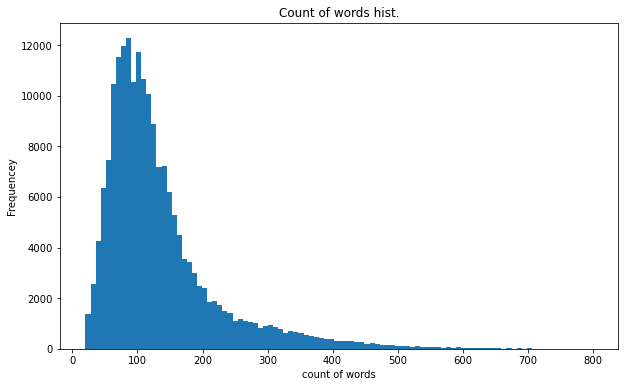

In [57]:
figure(figsize = (10,6))
plt.hist(lemmed_lyrics.count_words, bins = 100)
plt.title('Count of words hist.')
plt.xlabel('count of words')
plt.ylabel('Frequencey')
plt.show()

In [76]:
lemmed_lyrics[lemmed_lyrics.count_words <=180].shape[0] /lemmed_lyrics.shape[0]

0.8096627420090378

If we choose maximum lenght equals to 300, we will cover 94% of the lyrics actual lenght, if we choose 250 - we will cover 90%. We can try with 300, if we have a problem with vanishing gradient - we can decrease to 250 or even 200 (85%)

In [237]:
#all_lyrics_train = pop_train.Lyrics.append(rock_train.Lyrics)

In [238]:
#all_lyrics_train = all_lyrics_train.append(pop_train.Lyrics)

In [240]:

#all_lyrics_train = all_lyrics_train.append(jazz_train.Lyrics)

In [259]:
len(all_lyrics_train.unique())

43886

In [111]:
'''
unique_max = 0
for  i, text in enumerate(pop_train.Lyrics):
    if unique_max < pop_train.Lyrics.apply(set).apply(len)[i]:
        unique_max = pop_train.Lyrics.apply(set).apply(len)[i]
'''


In [112]:
#unique_max

27

In [246]:
### test
pop_train.count_words.sort_values()

3835      20
9428      20
13771     20
11725     20
5287      20
        ... 
19432    787
6342     790
614      791
15774    800
11581    800
Name: count_words, Length: 19000, dtype: int64

In [315]:
rock_train[rock_train.count_words <20]

,index,Artist,Song,Genre,Language,Lyrics,count_words,negative,neutral,positive,compound,Language_test


In [316]:
pop_test = pop_test.reset_index(drop= True)
pop_train = pop_train.reset_index(drop= True)
metal_train = metal_train.reset_index(drop= True)
metal_test = metal_test.reset_index(drop= True)
jazz_test = jazz_test.reset_index(drop= True)
jazz_train = jazz_train.reset_index(drop= True)
rock_test = rock_test.reset_index(drop= True)
rock_train = rock_train.reset_index(drop= True)

In [317]:
n = len(rock_test.Lyrics)
for index in range(n):
    with open(r"C:\Users\PC\Desktop\NN\Text calssification\test\Rock\Rock{0}.txt".format(index), "w+") as f:
        f.write(rock_test.Lyrics[index])
        f.close()

    


In [318]:
n = len(rock_train.Lyrics)
for index in range(n):
    with open(r"C:\Users\PC\Desktop\NN\Text calssification\train\Rock\Rock{0}.txt".format(index), "w+") as f:
        f.write(rock_train.Lyrics[index])
        f.close()

In [319]:
n = len(pop_train.Lyrics)
for index in range(n):
    with open(r"C:\Users\PC\Desktop\NN\Text calssification\train\Pop\Pop{0}.txt".format(index), "w+") as f:
        f.write(pop_train.Lyrics[index])
        f.close()

In [321]:
n = len(pop_test.Lyrics)
for index in range(n):
    with open(r"C:\Users\PC\Desktop\NN\Text calssification\test\Pop\Pop{0}.txt".format(index), "w+") as f:
        f.write(pop_test.Lyrics[index])
        f.close()

In [322]:
n = len(metal_test.Lyrics)
for index in range(n):
    with open(r"C:\Users\PC\Desktop\NN\Text calssification\test\Metal\Metal{0}.txt".format(index), "w+") as f:
        f.write(metal_test.Lyrics[index])
        f.close()

In [323]:
n = len(metal_train.Lyrics)
for index in range(n):
    with open(r"C:\Users\PC\Desktop\NN\Text calssification\train\Metal\Metal{0}.txt".format(index), "w+") as f:
        f.write(metal_train.Lyrics[index])
        f.close()

In [324]:
n = len(jazz_test.Lyrics)
for index in range(n):
    with open(r"C:\Users\PC\Desktop\NN\Text calssification\test\Jazz\Jazz{0}.txt".format(index), "w+") as f:
        f.write(jazz_test.Lyrics[index])
        f.close()

In [325]:
n = len(jazz_train.Lyrics)
for index in range(n):
    with open(r"C:\Users\PC\Desktop\NN\Text calssification\train\Jazz\Jazz{0}.txt".format(index), "w+") as f:
        f.write(jazz_train.Lyrics[index])
        f.close()

In [96]:
### test
#pd.read_csv (r"C:\Users\PC\Desktop\NN\NN Project\music_genres_preproces\train\Rock4.txt")

In [97]:
#index = 0
#with open(r"C:\Users\PC\Desktop\NN\Text calssification\train\Rock\Rock{0}.txt".format(index), "w+") as f:
    #f.write(rock_train.Lyrics[index])
    #f.close()

In [534]:
'''

index= 1
#loc= (r"C:\Users\PC\Desktop\NN\NN Project\music_genres_preproces\train\Rock)
with open(r"C:\Users\PC\Desktop\NN\NN Project\music_genres_preproces\train\Rock.txt", 'w') as f:
    f.write(rock_train.Lyrics[index])
    f.close()
'''



In [ ]:
# with open("newfile.txt", "w") as output:
        #output.write("%d %s" % (index + 1, value))

In [ ]:
'''
with open('C:\Users\PC\Desktop\NN\NN Project\music_genres_preproces\train\Rock\Rock.txt', 'w') as file_handler:
    index = 1
    for item in content:
        file_handler.write("{}. {}\n\n".format(index, item))
        index += 1

'''


In [419]:
#np.random.rand(len(rock)) < 0.8

array([ True, False,  True, ...,  True,  True,  True])

In [395]:
#np.random.rand(len(rock)) < 0.8

array([ True,  True,  True, ...,  True,  True,  True])

In [431]:
#d = {'a':[1,2,3,4,5,6], 'b':[1,2,3,4,5,6]}
#df = pd.DataFrame(d)


In [432]:
#bad_df = df.index.isin([3,5])

In [439]:
#a = rock.index.isin(rock_test.index)

,Artist,Song,Genre,Language,Lyrics,count_words,negative,neutral,positive,compound
0,the beatles,and i love her,Rock,en,give love thats saw love youd love love give e...,46,0.000,0.281,0.719,0.9970
1,lights,banner,Rock,en,maybe brick mortar whether run dont want anyth...,93,0.167,0.493,0.340,0.9665
2,bouncing souls,like a fish in water,Rock,en,glada allihopa glada glada glada allihopa glad...,51,0.000,0.418,0.582,0.9925
3,bette midler,boxing,Rock,en,howard strangest thing happened lately take go...,111,0.178,0.535,0.287,0.9423
4,the who,time is passing,Rock,en,im playing guitar sister bang jar glass set so...,109,0.145,0.681,0.174,0.4512
...,...,...,...,...,...,...,...,...,...,...
19995,dr. dog,the girl,Rock,en,he sleeping shoe dreaming worst living dirty l...,89,0.214,0.675,0.111,-0.8891
19996,neil diamond,face me,Rock,en,look away feel anger go straight head cause im...,112,0.247,0.507,0.246,-0.5017
19997,phil vassar,in a real love,Rock,en,eighteen makin minimum wage letterman jacket c...,127,0.115,0.663,0.222,0.9546
19998,fats domino,little bee,Rock,en,little bee little bee shes gal little bee litt...,52,0.040,0.589,0.371,0.9638


In [440]:
#rock[~a]

,Artist,Song,Genre,Language,Lyrics,count_words,negative,neutral,positive,compound
0,the beatles,and i love her,Rock,en,give love thats saw love youd love love give e...,46,0.000,0.281,0.719,0.9970
1,lights,banner,Rock,en,maybe brick mortar whether run dont want anyth...,93,0.167,0.493,0.340,0.9665
2,bouncing souls,like a fish in water,Rock,en,glada allihopa glada glada glada allihopa glad...,51,0.000,0.418,0.582,0.9925
3,bette midler,boxing,Rock,en,howard strangest thing happened lately take go...,111,0.178,0.535,0.287,0.9423
4,the who,time is passing,Rock,en,im playing guitar sister bang jar glass set so...,109,0.145,0.681,0.174,0.4512
...,...,...,...,...,...,...,...,...,...,...
19995,dr. dog,the girl,Rock,en,he sleeping shoe dreaming worst living dirty l...,89,0.214,0.675,0.111,-0.8891
19996,neil diamond,face me,Rock,en,look away feel anger go straight head cause im...,112,0.247,0.507,0.246,-0.5017
19997,phil vassar,in a real love,Rock,en,eighteen makin minimum wage letterman jacket c...,127,0.115,0.663,0.222,0.9546
19998,fats domino,little bee,Rock,en,little bee little bee shes gal little bee litt...,52,0.040,0.589,0.371,0.9638


In [355]:
#rock[np.random.rand(len(rock)) < 0.9]

,Artist,Song,Genre,Language,Lyrics,count_words,negative,neutral,positive,compound
0,the beatles,and i love her,Rock,en,give love thats saw love youd love love give e...,46,0.000,0.281,0.719,0.9970
1,lights,banner,Rock,en,maybe brick mortar whether run dont want anyth...,93,0.167,0.493,0.340,0.9665
2,bouncing souls,like a fish in water,Rock,en,glada allihopa glada glada glada allihopa glad...,51,0.000,0.418,0.582,0.9925
3,bette midler,boxing,Rock,en,howard strangest thing happened lately take go...,111,0.178,0.535,0.287,0.9423
4,the who,time is passing,Rock,en,im playing guitar sister bang jar glass set so...,109,0.145,0.681,0.174,0.4512
...,...,...,...,...,...,...,...,...,...,...
19995,dr. dog,the girl,Rock,en,he sleeping shoe dreaming worst living dirty l...,89,0.214,0.675,0.111,-0.8891
19996,neil diamond,face me,Rock,en,look away feel anger go straight head cause im...,112,0.247,0.507,0.246,-0.5017
19997,phil vassar,in a real love,Rock,en,eighteen makin minimum wage letterman jacket c...,127,0.115,0.663,0.222,0.9546
19998,fats domino,little bee,Rock,en,little bee little bee shes gal little bee litt...,52,0.040,0.589,0.371,0.9638


In [339]:
#pop = lemmed_lyrics[lemmed_lyrics.Genre== "Pop"].sample(n = 20000, random_state = 42)

In [327]:
%store lemmed_lyrics

Stored 'lemmed_lyrics' (DataFrame)


In [4]:
%store -r lemmed_lyrics

In [5]:
lemmed_lyrics

,Artist,Song,Genre,Language,Lyrics,count_words,negative,neutral,positive,compound
0,12 stones,world so cold,Rock,en,start pain followed hate fueled endless questi...,157,0.257,0.537,0.206,-0.9482
1,12 stones,broken,Rock,en,freedom alone alone patiently waiting phone ho...,138,0.445,0.447,0.108,-0.9970
2,12 stones,3 leaf loser,Rock,en,biting hand feed lying voice inside reach beg ...,73,0.150,0.633,0.217,0.6522
3,12 stones,anthem for the underdog,Rock,en,say know cant imagine wait across line thought...,65,0.222,0.617,0.161,-0.9032
4,12 stones,adrenaline,Rock,en,heart beating faster cant control feeling anym...,166,0.190,0.646,0.164,-0.5126
...,...,...,...,...,...,...,...,...,...,...
195432,zabot,part of me,Pop,ENGLISH,come let take away drama tonight know place go...,95,0.082,0.821,0.097,0.3859
195433,zabot,summer break,Pop,ENGLISH,dont care dont want gone forever young like su...,50,0.093,0.778,0.130,0.0187
195434,zélia duncan,bonita,Pop,ENGLISH,say bonita magic word would capture like soft ...,44,0.000,0.491,0.509,0.9885
195435,zélia duncan,dream a little dream of me,Pop,ENGLISH,star shining bright night breeze seem whisper ...,106,0.110,0.394,0.496,0.9950


In [257]:
for genre in lemmed_lyrics.Genre.unique():
    print(genre, lemmed_lyrics[lemmed_lyrics.Genre== genre].Genre.count())

Rock 88639
Metal 16136
Pop 70969
Jazz 12908
Hip-Hop 6725


In [134]:
lemmed_lyrics[lemmed_lyrics.Genre== 'Metal'].Genre.count()

16139